In [7]:
%matplotlib notebook
# %matplotlib inline

# %connect_info

import flow.misc
text = """
Jupyter connect hash:
{word}

To connect to current notebook:
    $> jupyter console --existing {filename}
    
"""
print(text.format(word=flow.misc.notebook_word(), filename=flow.misc.notebook_file(flow.misc.notebook_word())))
print("Last run: {}".format(flow.misc.timestamp()))


Jupyter connect hash:
promoting

To connect to current notebook:
    $> jupyter console --existing kernel-64172045-ee39-4145-824c-d8dcba36037c.json
    

Last run: 2018-10-05-11h40m17s


In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

import flow

## Is replay rate higher after reminder sessions (9/10/11) than un-reminded (6/8)?

* No, actually lower.
* Seems that the mice take some time to "settle in" after stims are on the screen.

In [26]:
THRESHOLD = 0.1

mice = flow.metadata.MouseSorter.frommeta(tags=['replay1'])

unreminded_events, unreminded_time, unreminded_runs = 0, 0, 0
reminded_events, reminded_time, reminded_runs = 0, 0, 0

In [27]:
for mouse in mice:
    for date in mouse.dates():
        for run in date.runs(runs=[6]):
            c2p = run.classify2p()
            t2p = run.trace2p()
            
            results = c2p.results()
            counts = flow.classify2p.counts(results, threshold=THRESHOLD)
            lo = t2p.lastonset()
            events = sum(counts['plus'] > lo) + sum(counts['minus'] > lo) + sum(counts['neutral'] > lo)

            frames = results.values()[0].shape[0]
            framerate = t2p.framerate

            unreminded_events += events
            unreminded_time += (frames - lo) * framerate
            unreminded_runs += 1

        for run in date.runs(runs=[9]):
            c2p = run.classify2p()
            t2p = run.trace2p()
            
            results = c2p.results()
            counts = flow.classify2p.counts(results, threshold=THRESHOLD)
            lo = t2p.lastonset()
            events = sum(counts['plus'] > lo) + sum(counts['minus'] > lo) + sum(counts['neutral'] > lo)

            frames = results.values()[0].shape[0]
            framerate = t2p.framerate

            reminded_events += events
            reminded_time += (frames - lo) * framerate
            reminded_runs += 1

In [28]:
print("""
Unreminded
==========
events = {}
time = {}
rate = {}

Reminded
========
events = {}
time = {}
rate = {}
""".format(unreminded_events, unreminded_time, unreminded_events/unreminded_time,
           reminded_events, reminded_time, reminded_events/reminded_time))


Unreminded
events = 710
time = 10372104.0
rate = 6.84528423548e-05

Reminded
events = 1601
time = 37884760.44
rate = 4.225973667e-05



## Does replay rate change over time within session?

* Generally goes up within session.
* At a smaller timescale, might be a slight increase at the very beginning of non-reminded trials.

In [29]:
THRESHOLD = 0.1

mice = flow.metadata.MouseSorter.frommeta(tags=['replay1'])
run_nums = [6, 8, 9, 10, 11]
result_list = []

In [30]:
for mouse in mice:
    for date in mouse.dates():
        for run in date.runs(runs=run_nums):
            c2p = run.classify2p()
            t2p = run.trace2p()
            
            results = c2p.results()
            counts = flow.classify2p.counts(results, threshold=THRESHOLD)
            
            lo = t2p.lastonset()
            framerate = t2p.framerate
            
            for replay_type in counts:
                c = counts[replay_type]
                c = c[c > lo]
                df = pd.DataFrame({
                    'time': c / framerate,
                    'type': replay_type,
                    'mouse': run.mouse,
                    'date': run.date,
                    'run': run.run})
                result_list.append(df)

result = pd.concat(result_list, ignore_index=True)

In [31]:
result.head()

,date,mouse,run,time,type
0,160816,AS20,6,1590.510006,minus
1,160818,AS20,6,694.125242,minus
2,160818,AS20,6,828.599096,minus
3,160818,AS20,6,933.699161,minus
4,160818,AS20,6,1543.641059,minus


In [32]:
result.shape

(6893, 5)

<IPython.core.display.Javascript object>


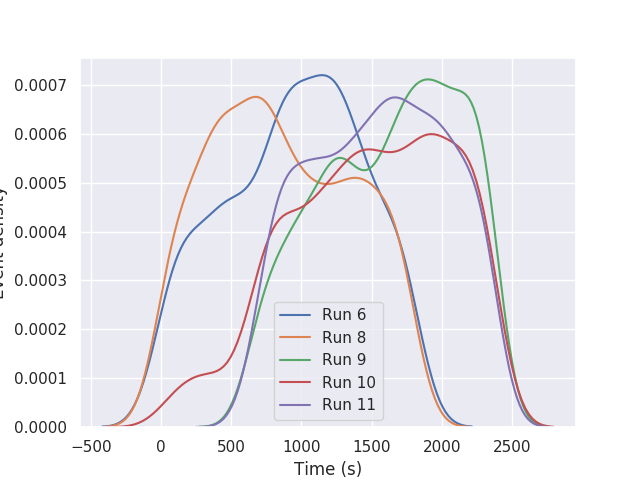

In [50]:
plt.figure()
for run, group in result.groupby('run'):
    sns.kdeplot(group.time, label='Run {}'.format(run), legend=True)
plt.xlabel('Time (s)')
plt.ylabel('Event density');

In [94]:
result_rezeroed = result.copy()

In [95]:
result_rezeroed.loc[result_rezeroed.run.isin([9,10,11]), 'time']-= 600
result_rezeroed = result_rezeroed.loc[(result_rezeroed.time > 0) & (result_rezeroed.time < 60)]

<IPython.core.display.Javascript object>


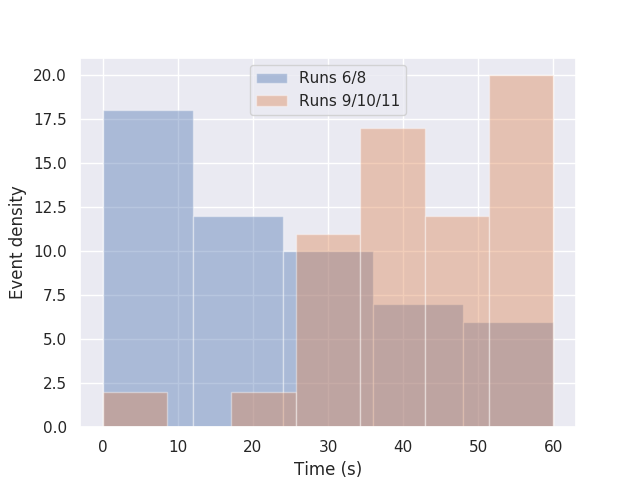

In [96]:
plt.figure()
sns.distplot(result_rezeroed.loc[result_rezeroed.run.isin([6, 8]), 'time'],
             label='Runs 6/8', hist=True, kde=False, bins=None, hist_kws={'range': (0, 60)})
sns.distplot(result_rezeroed.loc[result_rezeroed.run.isin([9, 10, 11]), 'time'],
             label='Runs 9/10/11', hist=True, kde=False, bins=None, hist_kws={'range': (0, 60)})
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Event density');